In [22]:
import numpy as np                # Library used to perform scientific computation
import pandas as pd               # Library used to build data structures
import matplotlib.pyplot as plt   # Library used to plot data
import time                       # Library used to evaluate computation time
import copy                       # Library used to perform the deepcopy and avoid 
from sympy import *               # Library used to manage visualize formulas and perform differentiation
init_printing()                   # Enable sympy LaTex print
plt.rcParams['figure.figsize'] = [10, 10] # Set plot size
ITERATIONS = 13                   # Constant number of iterations

## Tool setup
In this initial part we are going to develop and test some of the functions that will be useful for the computation of the Inexact Newton method

Initialization of the starting parameter vector $\omega$ and initialization of the conjugate gradient guess vector $d$.

In [50]:
wVal=np.array([[4.] ,[2.]])  
dVal=np.array([[4.] ,[3.]])

Creating symbol vectors to mantain the functions in verbose form and to differentiate  $F(\omega)$

In [24]:
w=[]
d=[]
nVar=2
# Creating array symbols w and d in order to perform computation on functions using sympy
for i in range(len(wVal)):       
    w.append(symbols('w%d'%i))
    d.append(symbols('d%d'%i))
w=np.array(w)
d=np.array(d)
fun = w[0]**2*w[1]**2  # F(w) Function Initianization
fun.evalf()            # Function Evaluation

Defining the gradient function, input: function to differentiate and symbols array containing the variables to differentiate on.

Computation of $\phi(\omega ;d)= \nabla F(\omega)^Td$ using the defined gradient function.

In [25]:
def gradient(fun,w):                   
    res = []
    for i in range(len(w)):
        res.append([diff(fun,w[i])])   # Perform differentiation on the function fun in each variable of the array w
    return np.array(res)

In [26]:
phi=np.dot(gradient(fun,w).T,d) # Performing dot product on the gradient of my starting function and 
phi[0].evalf()

Computation of $\nabla_\omega \phi(\omega ;d)= \nabla^2 F(\omega)d$ to create the Hessian Vector

In [49]:
gradphi=gradient(phi,w)                  #Computing the Hessian Vector product
g=gradient(fun,w)
gradphi=np.squeeze(gradphi, axis=1)      #Vertical squeeze to obtain  correct function formatting
print "Hessian vector of F(w) in function of w and d:",gradphi

Hessian vector of F(w) in function of w and d:
2.0*d0*w1**2 + 4.0*d1*w0*w1


Substitute the parameter vector values in the Hessian Vector and gradient so that the gradient will have numeric values and the Hessian Vector will be in function of the variable d

In [28]:
#Substitute value of w in the function 
for i in range(len(w)):
    for j in range(len(w)):
        gradphi[i]= gradphi[i][0].subs(w[j], wVal[j]) #Substituting parameter vector value in the Hessian vector
        g[i]=g[i][0].subs(w[j], wVal[j]) #Substituting parameter vector values in the gradient of the function
print "Hessian vector of F(w) in function of d:",gradphi
print "Gradient F(w):",g

Hessian vector of F(w) in function of d: [[8.0*d0 + 32.0*d1]
 [32.0*d0 + 32.0*d1]]
Gradient F(w): [[32.0000000000000]
 [64.0000000000000]]


Defining solveHessianVector(...) function that solve the Hessian-Vector substituting the values of the guess vector d

In [30]:
def solveHessianVector(gradphi,dVal):
    res = copy.deepcopy(gradphi) # Using deepcopy to copy the variable by value and not reference
    d=[]
    for i in range(len(dVal)): #Filling symbols vector based on the number of parameters used
        d.append(symbols('d%d'%i))
    d=np.array(d)
    for i in range(len(dVal)):
        for j in range(len(dVal)):
            res[i][0]= res[i][0].subs(d[j], dVal[j])   #Substituting guess value vector value in the Hessian vector
    return res
solveHessianVector(gradphi,-g)   #Output example

array([[-2304.00000000000],
       [-3072.00000000000]], dtype=object)

## Conjugate Gradient:

Implementation of the iterative conjugate gradient method to solve $Ax=b$ where $A$ is the matrix, $b$ the array and $x$ is the wanted array value.

In [29]:
def conjugateGradient(A,b,x):
    r = b - np.dot(A, x) 
    p=r 
    rOld = np.dot(r.T,r)
    for i in range(len(b)):     #Stop iteration corresponding to the size of b
        Ap = np.dot(A, p)
        alpha = (rOld/np.dot(p.T,Ap))
        x = x+alpha*p
        r = r - alpha*Ap
        rNew = np.dot(r.T,r)
        beta = rNew/rOld
        p = r + beta*p
        rOld = rNew
    return x
    
# Testing Conjugate Gradient
A = np.array([[4.,1.],[1.,3.]])
b = np.array([[1.],[2.]])
x = np.array([[2.],[1.]])
t1 = time.time()
print 'start'
x=conjugateGradient(A,b,x)
t2 = time.time()
print "Computation time:",t2 - t1
print "x:",x
print "Ax=b:",np.dot(A,x) # Result validation

start
Computation time: 0.000399827957153
Steps: [[0.09090909]
 [0.63636364]]
Ax=b: [[1.]
 [2.]]


## Newton Conjugate Gradient

Defining Newton Conjugate Gradient similarly to the previous conjugate method bu substituting the Hessian vector and gradient and performing compututation on the Hessian-vector.

In [31]:
def NewtonCG(gradphi,b,x):
    r = b - solveHessianVector(gradphi,x) #Substituting dot product with the Hessian vector using the guess values 
    p=r 
    rOld = np.dot(r.T,r)
    for i in range(len(b)):      #Stop iteration corresponding to the size of b, so of the gradient
        Ap = solveHessianVector(gradphi,p)
        alpha = (rOld/np.dot(p.T,Ap))
        x = x+alpha*p
        r = r - alpha*Ap
        rNew = np.dot(r.T,r)
        if sqrt(rNew) < 1e-10:
              break;
        beta = rNew/rOld
        p = r + beta*p
        rOld = rNew
    return x

# Testing Newton Conjugate Gradient
t1 = time.time()
print gradphi
res=NewtonCG(gradphi,-g,dVal) 
t2 = time.time()
print "Computation time:",t2 - t1
print "Steps:",res

[[8.0*d0 + 32.0*d1]
 [32.0*d0 + 32.0*d1]]
Computation time: 0.0143001079559
Steps: [[-1.33333333333333]
 [-0.666666666666665]]


Checking if the result of the Newton-CG satisfies $\nabla^2 F(\omega_k)s_k=-\nabla F(\omega_k)$

In [32]:
print "-Gradient:",solveHessianVector(gradphi,res)

-Gradient: [[-32.0000000000000]
 [-63.9999999999999]]


Defining generateFun(), it take as input the number of wanted parameter and return a sympy function that will be used to generate the dataset.

The function depend on w and x, but for visualization reasons we will generate the function using one variable x0 and multiple parameters. The generated function can be changed for mutate the nature of the problem.

In [33]:
def generateFun(nw): 
    w=[]
    x=symbols('x0')
    for i in range(nw): #Filling symbols vector based on the number of parameters used
        w.append(symbols('w%d'%i))
    w=np.array(w)
    fun=0
    #function generation 
    for i in range(0,nw):
        fun += w[i]*np.power(x, i)       
    return fun

#Testing created function
nw=4
fun = generateFun(nw)
fun

Defining generateDS(), it takes as inputs a sympy function, w values for generating the points, the size of the dataset and the wanted noise.

In [34]:
def generateDS(fun,wVal,size,noise):
    elem=[]
    y=[]
    clmn =[] 
    x=[]
    w=[]
    for i in range(len(wVal)):
        elem.append(np.linspace(-2, 2, size))
        clmn.append('x%d'%i)
        w.append(symbols('w%d'%i))
        x.append(symbols('x%d'%i))
    clmn.append('y')
    res=copy.deepcopy(fun)
    for i in range(size):
        for k in range(len(wVal)):
            res=res.subs(w[k], wVal[k])
            res=res.subs(x[k], elem[k][i])
        y.append(res +np.random.normal()*noise)
        res=copy.deepcopy(fun)
    y=np.squeeze(np.array(y))
    elem.append(y)
    elem=np.array(elem).T   
    df= pd.DataFrame(elem, columns=clmn).astype(float)
    return df

In [35]:
def solveFun(fun,sample,wVal):
    sumf = 0
    w=[]
    x=[]
    for i in range(len(wVal)):
        w.append(symbols('w%d'%i))
        x.append(symbols('x%d'%i))
    y=symbols('y')
    fun1=copy.deepcopy(fun)
    for i in range(len(sample)):
            for j in range(len(fun1)):
                for k in range(len(w)):
                    fun1[j][0]=fun1[j][0].subs(w[k], wVal[k][0])
                    fun1[j][0]=fun1[j][0].subs(x[k], sample.iloc[i][k])
                fun1[j][0]=fun1[j][0].subs(y, sample.iloc[i][len(w)]) 
            sumf+=fun1
            fun1=copy.deepcopy(fun)
    sumf=sumf/(2.*len(sample))
    return sumf

## Subsampled Hessian-Free Inexact Newton Method

In [36]:
def selectA(errfun,wVal,res,sampleFut,g):
    a=[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]
    n=0.01
    alpha=0.01
    sumF=0
    sumFP=0
    for i in range(len(a)):   
        wVal1=wVal+a[i]*res
        sumF=solveFun(errfun,sampleFut,wVal)
        sumFP=solveFun(errfun,sampleFut,wVal1)
        if (sumFP<sumF+n*a[i]*np.dot(g.T,res)):
            alpha=a[i]
    return alpha

In [37]:
def subSampledHessianFree(errfun,df,wVal,empErr):
    #sh<s
    s=40
    sh=20
    dVal=[]
    for i in range(nw):
        dVal.append([1.])
    dVal=np.array(dVal)
    sample=df.sample(s)
    sampleh=df.sample(sh)
    d=[]
    w=[]
    x=[]
    for i in range(nw): #Filling symbols vector based on the number of parameters used
        d.append(symbols('d%d'%i))
        w.append(symbols('w%d'%i))
        x.append(symbols('x%d'%i))
    for i in range(ITERATIONS):
        g=gradient(errfun,w)
        phi=np.dot(g.T,d)        
        gradphi=gradient(phi,w) 
        gradphi=np.squeeze(gradphi, axis=1) #Vertical squeeze used for good function formatting
        #Compute gradient
        sumg=solveFun(g,sample,wVal)
        sumgradphi = solveFun(gradphi,sampleh,wVal)
        dVal=NewtonCG(sumgradphi,-sumg,dVal)
        sample=df.sample(s)
        sampleh=df.sample(sh)
        lr= selectA(np.array([[errfun]]),wVal,dVal,sample,sumg)
        wVal=wVal+lr*dVal
        empErr.append(np.squeeze(solveFun(np.array([[errfun]]),sample,wVal)))
    return wVal

## Testing Phase

In [38]:
def print2D(wValInit,wValFin,empErr):
    df.plot.scatter("x0","y",grid=True)
    xdf = pd.DataFrame(np.linspace(-2, 2, 20))
    ax = plt.axes()
    yfin = []
    yinit =[]
    w=[]
    x=[]
    for i in range(nw): #Filling symbols vector based on the number of parameters used
        w.append(symbols('w%d'%i))
        x.append(symbols('x%d'%i))
    w=np.array(w)
    x=np.array(x)
    res1=copy.deepcopy(fun)
    res2=copy.deepcopy(fun)
    for i in range (20):
        res1=res1.subs(x[0], xdf[0][i])
        res2=res2.subs(x[0], xdf[0][i])
        for j in range(nw):   
            res1=res1.subs(w[j], wValFin[j][0])
            res2=res2.subs(w[j], wValInit[j][0])
        yfin.append(res1)
        yinit.append(res2)
        res1=copy.deepcopy(fun)
        res2=copy.deepcopy(fun)

    ax.set_title('Model')
    ax.plot(xdf, yfin,color='r',linewidth=2.5)
    #ax.plot(xdf, yinit,color='b',linewidth=2.5)   
    fig1, ax2 = plt.subplots()
    xln = np.linspace(0, ITERATIONS, ITERATIONS)
    ax2 = plt.axes()    
    ax2.set_title('Empirical Risk')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Empirical Risk')
    plt.grid()
    ax2.plot(xln, empErr,linewidth=2.5,)

# 2 Parameter

In [39]:
nw=2
size=400
wVal = np.random.randn(1,nw)[0]
wValInit = []
for i in range(nw):
        wValInit.append([40])
fun = generateFun(nw)
noise=1.5
df=generateDS(fun,wVal,size,noise)
y=symbols('y')
errfun=(fun -y)**2
print "Generated function:",fun
print "Used value of W for generate the Dataset:",wVal
print "Error function:",errfun

Generated function: w0 + w1*x0
Used value of W for generate the Dataset: [-1.37770485  0.47567684]
Error function: (w0 + w1*x0 - y)**2


Computation time: 38.4010210037 s
Final Parameter Vector: [[-1.01276431880882]
 [0.250699096422541]]


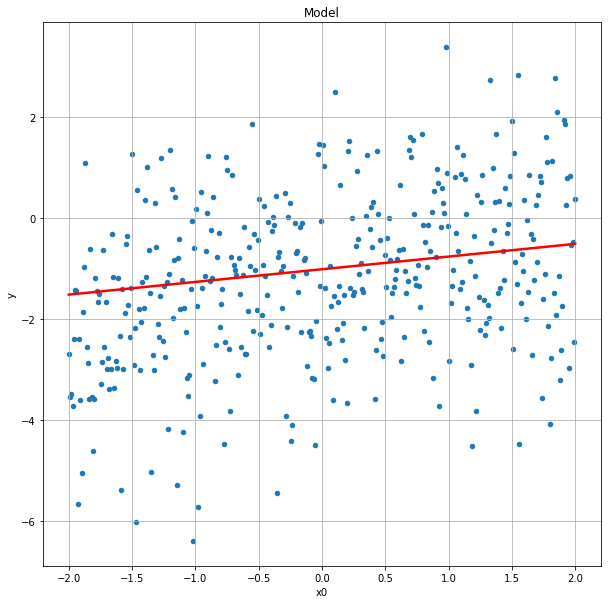

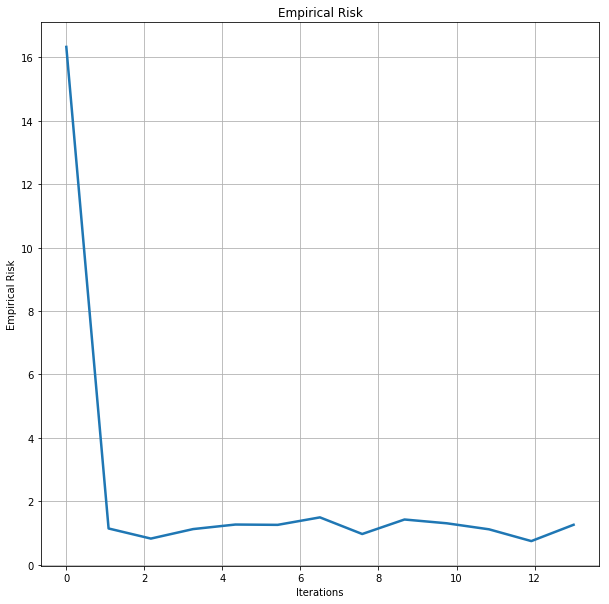

In [40]:
empErr=[]
t1 = time.time()
wValFin=subSampledHessianFree(errfun,df,copy.deepcopy(wValInit),empErr)
t2 = time.time()
print "Computation time:",t2 - t1,"s"
print "Final Parameter Vector:",wValFin
print2D(wValInit,wValFin,empErr)

# 3 Parameter

In [41]:
nw=3
size=400
wVal = np.random.randn(1,nw)[0]
wValInit = []
for i in range(nw):
        wValInit.append([40])
fun = generateFun(nw)
noise=2
df=generateDS(fun,wVal,size,noise)
y=symbols('y')
errfun=(fun -y)**2
print "Generated function:",fun
print "Used value of W for generate the Dataset:",wVal
print "Error function:",errfun

Generated function: w0 + w1*x0 + w2*x0**2
Used value of W for generate the Dataset: [ 0.51977161 -0.58817334 -1.08068713]
Error function: (w0 + w1*x0 + w2*x0**2 - y)**2


Computation time: 59.5039870739 s
Final Parameter Vector: [[0.273624732466849]
 [-0.147458922253762]
 [-0.970822799343719]]


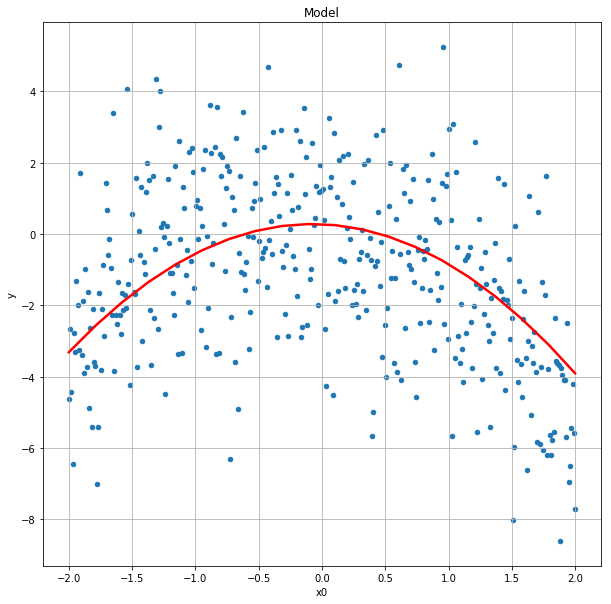

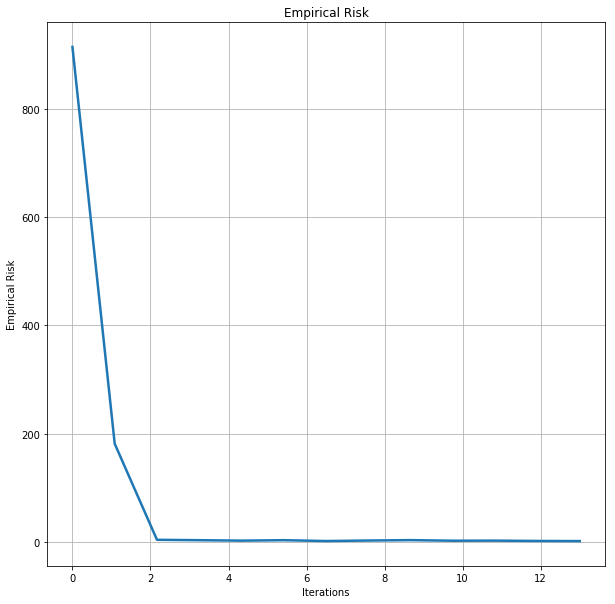

In [42]:
empErr=[]
t1 = time.time()
wValFin=subSampledHessianFree(errfun,df,copy.deepcopy(wValInit),empErr)
t2 = time.time()
print "Computation time:",t2 - t1,"s"
print "Final Parameter Vector:",wValFin
print2D(wValInit,wValFin,empErr)

# 4 Parameter

In [43]:
nw=4
size=400
wVal = np.random.randn(1,nw)[0]
wValInit = []
for i in range(nw):
        wValInit.append([40])
fun = generateFun(nw)
noise=2
df=generateDS(fun,wVal,size,noise)
y=symbols('y')
errfun=(fun -y)**2
print "Generated function:",fun
print "Used value of W for generate the Dataset:",wVal
print "Error function:",errfun

Generated function: w0 + w1*x0 + w2*x0**2 + w3*x0**3
Used value of W for generate the Dataset: [-1.30907949 -2.40480645 -0.34589956 -0.39208418]
Error function: (w0 + w1*x0 + w2*x0**2 + w3*x0**3 - y)**2


Computation time: 86.9673609734 s
Final Parameter Vector: [[-1.38176389758768]
 [-2.42808533924664]
 [-0.427072741530338]
 [-0.466599204774003]]


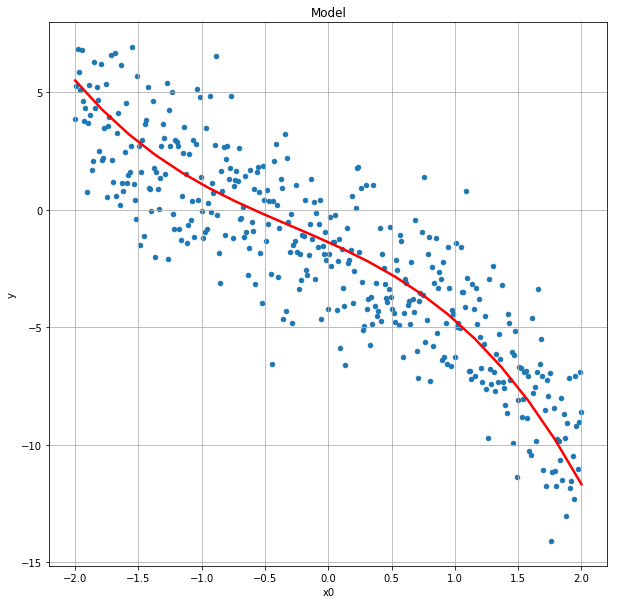

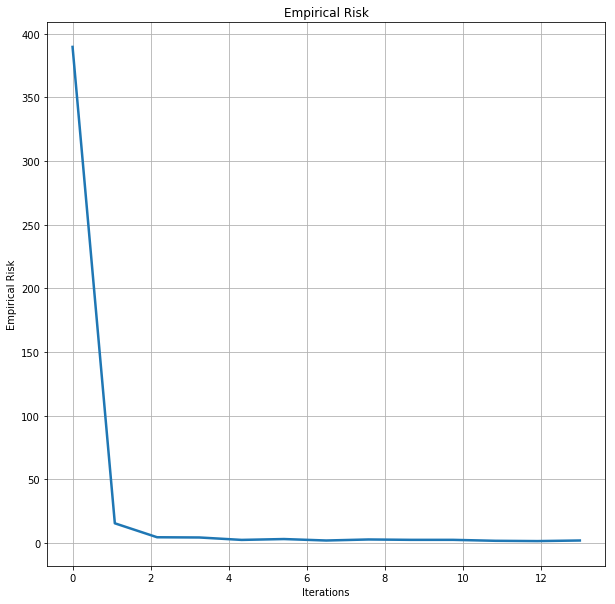

In [44]:
empErr=[]
t1 = time.time()
wValFin=subSampledHessianFree(errfun,df,copy.deepcopy(wValInit),empErr)
t2 = time.time()
print "Computation time:",t2 - t1,"s"
print "Final Parameter Vector:",wValFin
print2D(wValInit,wValFin,empErr)

# 5 Parameters

In [45]:
nw=5
size=400
wVal = np.random.randn(1,nw)[0]
wValInit = []
for i in range(nw):
        wValInit.append([40])
fun = generateFun(nw)
noise=2
df=generateDS(fun,wVal,size,noise)
y=symbols('y')
errfun=(fun -y)**2
print "Generated function:",fun
print "Used value of W for generate the Dataset:",wVal
print "Error function:",errfun

Generated function: w0 + w1*x0 + w2*x0**2 + w3*x0**3 + w4*x0**4
Used value of W for generate the Dataset: [-1.89752    -1.00070927  1.03739835 -0.3824817   1.39208397]
Error function: (w0 + w1*x0 + w2*x0**2 + w3*x0**3 + w4*x0**4 - y)**2


Computation time: 139.062330008 s
Final Parameter Vector: [[-1.85029301122640]
 [-0.0595143159048359]
 [0.672274258869168]
 [-0.534076901797494]
 [1.58884698072883]]


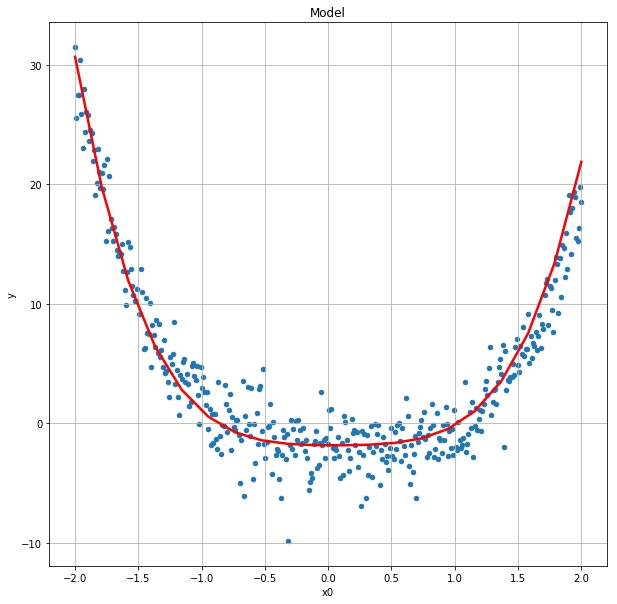

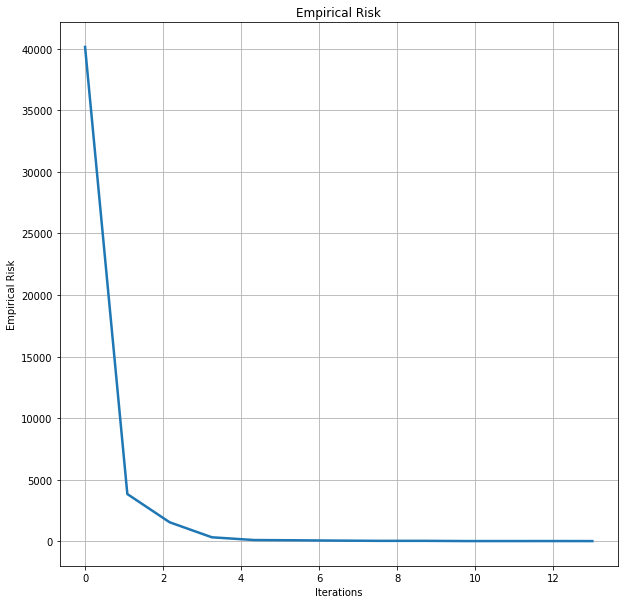

In [46]:
empErr=[]
t1 = time.time()
wValFin=subSampledHessianFree(errfun,df,copy.deepcopy(wValInit),empErr)
t2 = time.time()
print "Computation time:",t2 - t1,"s"
print "Final Parameter Vector:",wValFin
print2D(wValInit,wValFin,empErr)